# LAB 2

## Download LLM

In [1]:
import torch 
from transformers import AutoTokenizer, AutoModelForCausalLM

tokenizer = AutoTokenizer.from_pretrained("meta-llama/Llama-2-7b-hf", trust_remote_code=True)
model = AutoModelForCausalLM.from_pretrained("apple/OpenELM-270M-Instruct", trust_remote_code=True)
model.eval()


OpenELMForCausalLM(
  (transformer): OpenELMModel(
    (token_embeddings): Embedding(32000, 1280)
    (layers): ModuleList(
      (0): OpenELMDecoderLayer(
        (attn): OpenELMMultiHeadCausalAttention(
          query_heads=12, key_heads=3, value_heads=3
          (qkv_proj): Linear(in_features=1280, out_features=1152, bias=False)
          (pos_embedding): OpenELMRotaryEmbedding(	model_dim=64, max_seq_length=4096, freq_constant=10000)
          (q_norm): OpenELMRMSNorm(num_features=64, eps=1e-06)
          (k_norm): OpenELMRMSNorm(num_features=64, eps=1e-06)
          (out_proj): Linear(in_features=768, out_features=1280, bias=False)
        )
        (ffn): OpenELMFeedForwardNetwork(
          (ffn_with_glu) : True
          (proj_1): Linear(in_features=1280, out_features=1536, bias=False)
          (proj_2): Linear(in_features=768, out_features=1280, bias=False)
          (act): SiLU()
        )
        (ffn_norm): OpenELMRMSNorm(num_features=1280, eps=1e-06)
        (attn_norm):

### Collect largest matmul in LLM 

In [2]:
import torch
import torch.nn.functional as F
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"
# Initialize dictionary to store activations
activations = {}

prompt = "Arm is a company that" 
inputs = tokenizer(prompt, return_tensors="pt")

# Define a hook function to capture input
def get_activation_input(name):
    def hook(model, input, output):
        # 'input' is a tuple; we take the first element for the input tensor
        activations[name] = output[0]
    return hook

# Select the transformer block and register the hook
layer_idx = 12  # Select the transformer block of your choosing
layer = model.transformer.norm
hook_handle = layer.register_forward_hook(get_activation_input('token_activations'))

# Run the model forward pass
with torch.no_grad():
    model(**inputs)

# Extract the weight matrix and the input activation tensor from the hook
W = model.transformer.token_embeddings.weight.data.clone()
X = activations['token_activations']
hook_handle.remove()
print(f"The collected weight matrix has shape {W.shape[0]}x{W.shape[1]} (output_channels x input_channels)")
print(f"The collected activation tensor has shape {X.shape[0]}x{X.shape[1]} (sequence_length x input_channels)")

The collected weight matrix has shape 32000x1280 (output_channels x input_channels)
The collected activation tensor has shape 6x1280 (sequence_length x input_channels)


### Benchmark torch latency for the matmul

In [3]:
import time

def measure_time():
    start = time.perf_counter()
    with torch.no_grad():
        y = F.linear(X, W, None)
    end = time.perf_counter()
    return (end - start) * 1_000_000  # Convert to microseconds

# Run multiple times and average
times = [measure_time() for _ in range(100)]
avg_time = sum(times) / len(times)
print(f"{avg_time:.2f} µs")

34909.52 µs


### Write Data out so we can benchmark with c++

In [4]:
!mkdir src/cpp/assets/

X.numpy().tofile("src/cpp/assets/x_fp32.bin")
W.numpy().tofile("src/cpp/assets/w_fp32.bin")

mkdir: cannot create directory ‘src/cpp/assets/’: File exists


## Naive Matmul Operator

In [5]:
%%writefile src/cpp/naive/kernel.cpp

#include <stdio.h>
#include <stdlib.h>
#include <time.h>

void matrix_multiply_naive(float* A, float* B, float* C, int M, int K, int N) {
    // # M: the number of rows in the left hand matric (M = A.shape[0])
    // # K: the inner dimensions of the multiple (K == A.shape[1] == B.shape[0])
    // # N: the number of columns in the right hand matrix (N == B.shape[1])
    for (int i = 0; i < M; i++) {
        for (int j = 0; j < N; j++) {
            C[i * N + j] = 0;
            for (int k = 0; k < K; k++) {
                C[i * N + j] += A[i * K + k] * B[k * N + j];
            }
        }
    }
}

Overwriting src/cpp/naive/kernel.cpp


### Benchmark the Naive Operator

In [6]:
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

!mkdir -p src/cpp/naive/build 

# Navigate to the build directory
%cd src/cpp/naive/build

# Run cmake
!cmake ..

# Build the project using make
!make

print("======> Running benchmark")
# Run the benchmark binary
!./benchmark_naive

# Navigate back to the original directory after execution
%cd -

/home/ubuntu/Generative_AI_on_arm/src/cpp/naive/build
-- Configuring done (0.0s)
-- Generating done (0.0s)
-- Build files have been written to: /home/ubuntu/Generative_AI_on_arm/src/cpp/naive/build


/home/ubuntu/Generative_AI_on_arm/my_env/lib/python3.12/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


[ 33%] Building CXX object CMakeFiles/benchmark_naive.dir/benchmark_naive.cpp.o
[ 66%] Building CXX object CMakeFiles/benchmark_naive.dir/kernel.cpp.o
[100%] Linking CXX executable benchmark_naive
[100%] Built target benchmark_naive
======> Running benchmark
Time taken: 1224.93 microseconds
/home/ubuntu/Generative_AI_on_arm


# Clone KleidiAI

In [7]:
!git clone https://git.gitlab.arm.com/kleidi/kleidiai.git

fatal: destination path 'kleidiai' already exists and is not an empty directory.


## Understanding the KleidiAI Micro-Kernel

...

## Creating a Kleidi Kernel

...

# FP32 NEON MLA

In [8]:
%%writefile src/cpp/f32_f32_f32p/kernel.cpp

#include <arm_neon.h>

#include "kai_matmul_clamp_f32_f32_f32p8x1biasf32_6x8x4_neon_mla.h"
#include "kai_matmul_clamp_f32_f32_f32p_interface.h"


constexpr kai_matmul_clamp_f32_f32_f32p_ukernel ukernel{
    kai_get_m_step_matmul_clamp_f32_f32_f32p8x1biasf32_6x8x4_neon_mla,
    kai_get_n_step_matmul_clamp_f32_f32_f32p8x1biasf32_6x8x4_neon_mla,
    kai_get_nr_matmul_clamp_f32_f32_f32p8x1biasf32_6x8x4_neon_mla,
    kai_get_kr_matmul_clamp_f32_f32_f32p8x1biasf32_6x8x4_neon_mla,
    kai_get_sr_matmul_clamp_f32_f32_f32p8x1biasf32_6x8x4_neon_mla,
    kai_get_lhs_offset_matmul_clamp_f32_f32_f32p8x1biasf32_6x8x4_neon_mla,
    kai_get_rhs_packed_offset_matmul_clamp_f32_f32_f32p8x1biasf32_6x8x4_neon_mla,
    kai_get_dst_offset_matmul_clamp_f32_f32_f32p8x1biasf32_6x8x4_neon_mla,
    kai_get_dst_size_matmul_clamp_f32_f32_f32p8x1biasf32_6x8x4_neon_mla,
    kai_run_matmul_clamp_f32_f32_f32p8x1biasf32_6x8x4_neon_mla};

Overwriting src/cpp/f32_f32_f32p/kernel.cpp


### Build and Benchmark

In [ ]:
!mkdir -p src/cpp/f32_f32_f32p/build 

# Navigate to the build directory
%cd src/cpp/f32_f32_f32p/build

# Run cmake
!cmake ..

# Build the project using make
!make

print("======> Running benchmark")
# Run the benchmark binary
!./benchmark_f32

# Navigate back to the original directory after execution
%cd -

/home/ubuntu/Generative_AI_on_arm/src/cpp/f32_f32_f32p/build
-- Configuring done (0.0s)
-- Generating done (0.0s)
-- Build files have been written to: /home/ubuntu/Generative_AI_on_arm/src/cpp/f32_f32_f32p/build
[  6%] Building CXX object CMakeFiles/benchmark_f32.dir/benchmark_f32.cpp.o
[ 13%] Building CXX object CMakeFiles/benchmark_f32.dir/kernel.cpp.o
[ 20%] Linking CXX executable benchmark_f32
[ 33%] Built target benchmark_f32
[ 40%] Building CXX object CMakeFiles/benchmark_f32_scaling.dir/benchmark_f32_scaling.cpp.o
[ 46%] Building CXX object CMakeFiles/benchmark_f32_scaling.dir/kernel.cpp.o


# FP16 NEON MLA 

In [12]:
%%writefile src/cpp/f16_f16_f16p/kernel.cpp

#include <arm_neon.h>

#include "kai_matmul_clamp_f16_f16_f16p16x1biasf16_6x16x8_neon_mla.h"
#include "kai_matmul_clamp_f16_f16_f16p_interface.h"

constexpr kai_matmul_clamp_f16_f16_f16p_ukernel ukernel{
    kai_get_m_step_matmul_clamp_f16_f16_f16p16x1biasf16_6x16x8_neon_mla,
    kai_get_n_step_matmul_clamp_f16_f16_f16p16x1biasf16_6x16x8_neon_mla,
    kai_get_nr_matmul_clamp_f16_f16_f16p16x1biasf16_6x16x8_neon_mla,
    kai_get_kr_matmul_clamp_f16_f16_f16p16x1biasf16_6x16x8_neon_mla,
    kai_get_sr_matmul_clamp_f16_f16_f16p16x1biasf16_6x16x8_neon_mla,
    kai_get_lhs_offset_matmul_clamp_f16_f16_f16p16x1biasf16_6x16x8_neon_mla,
    kai_get_rhs_packed_offset_matmul_clamp_f16_f16_f16p16x1biasf16_6x16x8_neon_mla,
    kai_get_dst_offset_matmul_clamp_f16_f16_f16p16x1biasf16_6x16x8_neon_mla,
    kai_get_dst_size_matmul_clamp_f16_f16_f16p16x1biasf16_6x16x8_neon_mla,
    kai_run_matmul_clamp_f16_f16_f16p16x1biasf16_6x16x8_neon_mla};

Overwriting src/cpp/f16_f16_f16p/kernel.cpp


### Build and Benchmark

In [13]:
!mkdir -p src/cpp/f16_f16_f16p/build 

# Navigate to the build directory
%cd src/cpp/f16_f16_f16p/build

# Run cmake
!cmake ..

# Build the project using make
!make

print("======> Running benchmark")
# Run the benchmark binary
!./benchmark_f16

# Navigate back to the original directory after execution
%cd -

/home/ubuntu/Generative_AI_on_arm/src/cpp/f16_f16_f16p/build
-- Configuring done (0.0s)
-- Generating done (0.0s)
-- Build files have been written to: /home/ubuntu/Generative_AI_on_arm/src/cpp/f16_f16_f16p/build
[ 10%] Building CXX object CMakeFiles/benchmark_f16.dir/benchmark_f16.cpp.o
[ 20%] Building CXX object CMakeFiles/benchmark_f16.dir/kernel.cpp.o
[ 30%] Linking CXX executable benchmark_f16
[ 50%] Built target benchmark_f16
[ 60%] Building CXX object CMakeFiles/benchmark_f16_scaling.dir/benchmark_f16_scaling.cpp.o
[ 70%] Building CXX object CMakeFiles/benchmark_f16_scaling.dir/kernel.cpp.o
[ 80%] Linking CXX executable benchmark_f16_scaling
[100%] Built target benchmark_f16_scaling
======> Running benchmark
Time taken: 6.461 microseconds
/home/ubuntu/Generative_AI_on_arm


## DotProd

In [14]:
%%writefile src/cpp/f32_i8_i4_dotprod/kernel.cpp

#include <arm_neon.h>
#include <string>

#include "kai_matmul_clamp_f32_qsi8d32p1x8_qsi4c32p4x8_1x4x32_neon_dotprod.h"
#include "kai_matmul_clamp_f32_qsi8d32p_qsi4c32p_interface.h"


constexpr kai_matmul_clamp_f32_qsi8d32p_qsi4c32p_ukernel ukernel{
    kai_get_m_step_matmul_clamp_f32_qsi8d32p1x8_qsi4c32p4x8_1x4x32_neon_dotprod,
    kai_get_n_step_matmul_clamp_f32_qsi8d32p1x8_qsi4c32p4x8_1x4x32_neon_dotprod,
    kai_get_mr_matmul_clamp_f32_qsi8d32p1x8_qsi4c32p4x8_1x4x32_neon_dotprod,
    kai_get_nr_matmul_clamp_f32_qsi8d32p1x8_qsi4c32p4x8_1x4x32_neon_dotprod,
    kai_get_kr_matmul_clamp_f32_qsi8d32p1x8_qsi4c32p4x8_1x4x32_neon_dotprod,
    kai_get_sr_matmul_clamp_f32_qsi8d32p1x8_qsi4c32p4x8_1x4x32_neon_dotprod,
    kai_get_lhs_packed_offset_matmul_clamp_f32_qsi8d32p1x8_qsi4c32p4x8_1x4x32_neon_dotprod,
    kai_get_rhs_packed_offset_matmul_clamp_f32_qsi8d32p1x8_qsi4c32p4x8_1x4x32_neon_dotprod,
    kai_get_dst_offset_matmul_clamp_f32_qsi8d32p1x8_qsi4c32p4x8_1x4x32_neon_dotprod,
    kai_get_dst_size_matmul_clamp_f32_qsi8d32p1x8_qsi4c32p4x8_1x4x32_neon_dotprod,
    kai_run_matmul_clamp_f32_qsi8d32p1x8_qsi4c32p4x8_1x4x32_neon_dotprod};

Overwriting src/cpp/f32_i8_i4_dotprod/kernel.cpp


### Build and Run 

In [15]:
!mkdir -p src/cpp/f32_i8_i4_dotprod/build 

# Navigate to the build directory
%cd src/cpp/f32_i8_i4_dotprod/build


# Run cmake
!cmake ..

# Build the project using make
!make

print("======> Running benchmark")
# Run the benchmark binary
!./benchmark_dotprod

# Navigate back to the original directory after execution
%cd -

/home/ubuntu/Generative_AI_on_arm/src/cpp/f32_i8_i4_dotprod/build
-- Configuring done (0.0s)
-- Generating done (0.0s)
-- Build files have been written to: /home/ubuntu/Generative_AI_on_arm/src/cpp/f32_i8_i4_dotprod/build
[  8%] Building CXX object CMakeFiles/benchmark_dotprod.dir/benchmark_i8_dotprod.cpp.o
[ 16%] Building CXX object CMakeFiles/benchmark_dotprod.dir/kernel.cpp.o
[ 25%] Linking CXX executable benchmark_dotprod
[ 50%] Built target benchmark_dotprod
[ 58%] Building CXX object CMakeFiles/benchmark_dotprod_scaling.dir/benchmark_i8_dotprod_scaling.cpp.o
[ 66%] Building CXX object CMakeFiles/benchmark_dotprod_scaling.dir/kernel.cpp.o
[ 75%] Linking CXX executable benchmark_dotprod_scaling
[100%] Built target benchmark_dotprod_scaling
======> Running benchmark
Time taken: 12.705 microseconds
/home/ubuntu/Generative_AI_on_arm


## I8MM

In [1]:
%%writefile src/cpp/f32_i8_i4_i8mm/kernel.cpp

#include <arm_neon.h>
#include "kai_matmul_clamp_f32_qsi8d32p4x8_qsi4c32p4x8_8x4x32_neon_i8mm.h"
#include "kai_matmul_clamp_f32_qsi8d32p_qsi4c32p_interface.h"


constexpr kai_matmul_clamp_f32_qsi8d32p_qsi4c32p_ukernel ukernel{
    kai_get_m_step_matmul_clamp_f32_qsi8d32p4x8_qsi4c32p4x8_8x4x32_neon_i8mm,
    kai_get_n_step_matmul_clamp_f32_qsi8d32p4x8_qsi4c32p4x8_8x4x32_neon_i8mm,
    kai_get_mr_matmul_clamp_f32_qsi8d32p4x8_qsi4c32p4x8_8x4x32_neon_i8mm,
    kai_get_nr_matmul_clamp_f32_qsi8d32p4x8_qsi4c32p4x8_8x4x32_neon_i8mm,
    kai_get_kr_matmul_clamp_f32_qsi8d32p4x8_qsi4c32p4x8_8x4x32_neon_i8mm,
    kai_get_sr_matmul_clamp_f32_qsi8d32p4x8_qsi4c32p4x8_8x4x32_neon_i8mm,
    kai_get_lhs_packed_offset_matmul_clamp_f32_qsi8d32p4x8_qsi4c32p4x8_8x4x32_neon_i8mm,
    kai_get_rhs_packed_offset_matmul_clamp_f32_qsi8d32p4x8_qsi4c32p4x8_8x4x32_neon_i8mm,
    kai_get_dst_offset_matmul_clamp_f32_qsi8d32p4x8_qsi4c32p4x8_8x4x32_neon_i8mm,
    kai_get_dst_size_matmul_clamp_f32_qsi8d32p4x8_qsi4c32p4x8_8x4x32_neon_i8mm,
    kai_run_matmul_clamp_f32_qsi8d32p4x8_qsi4c32p4x8_8x4x32_neon_i8mm};



Overwriting src/cpp/f32_i8_i4_i8mm/kernel.cpp


### Build and Run 

In [2]:
!mkdir -p src/cpp/f32_i8_i4_dotprod/build 

# Navigate to the build directory
%cd src/cpp/f32_i8_i4_i8mm/build


# Run cmake
!cmake ..

# Build the project using make
!make

print("======> Running benchmark")
# Run the benchmark binary
!./benchmark_i8mm

# Navigate back to the original directory after execution
%cd -

/home/ubuntu/Generative_AI_on_arm/src/cpp/f32_i8_i4_i8mm/build
-- Configuring done (0.0s)
-- Generating done (0.0s)
-- Build files have been written to: /home/ubuntu/Generative_AI_on_arm/src/cpp/f32_i8_i4_i8mm/build
[  5%] Building CXX object CMakeFiles/benchmark_i8_i8mm.dir/benchmark_i8_i8mm.cpp.o


/home/ubuntu/Generative_AI_on_arm/my_env/lib/python3.12/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


[ 11%] Building CXX object CMakeFiles/benchmark_i8_i8mm.dir/kernel.cpp.o
[ 16%] Linking CXX executable benchmark_i8_i8mm
[ 33%] Built target benchmark_i8_i8mm
[ 38%] Building CXX object CMakeFiles/benchmark_i8_i8mm_scaling.dir/benchmark_i8_i8mm_scaling.cpp.o
[ 44%] Building CXX object CMakeFiles/benchmark_i8_i8mm_scaling.dir/kernel.cpp.o
[ 50%] Linking CXX executable benchmark_i8_i8mm_scaling
[ 66%] Built target benchmark_i8_i8mm_scaling
[ 72%] Building CXX object CMakeFiles/kai_i8_i8mm_inf.dir/kai_i8_i8mm_inf.cpp.o
[ 77%] Building CXX object CMakeFiles/kai_i8_i8mm_inf.dir/kernel.cpp.o
[ 83%] Building C object CMakeFiles/kai_i8_i8mm_inf.dir/home/ubuntu/Generative_AI_on_arm/kleidiai/kai/ukernels/matmul/matmul_clamp_f32_qsi8d32p_qsi4c32p/kai_matmul_clamp_f32_qsi8d32p4x8_qsi4c32p4x8_8x4x32_neon_i8mm.c.o
[ 88%] Building C object CMakeFiles/kai_i8_i8mm_inf.dir/home/ubuntu/Generative_AI_on_arm/kleidiai/kai/ukernels/matmul/pack/kai_rhs_pack_nxk_qsi4c32pscalef16_qsu4c32s16s0.c.o
[ 94%] Buildin

### Plot Latency Scaling 

In [3]:
%%writefile src/cpp/common/sizes.cpp

int sizes[] = {32, 64, 128, 256, 512, 1024, 2048};

Overwriting src/cpp/common/sizes.cpp


if changing sizes you should build the code again. 

In [2]:
%cd src/cpp/f32_f32_f32p/build
!cmake .. && make
%cd -
%cd src/cpp/f16_f16_f16p/build
!cmake .. && make
%cd -
%cd src/cpp/f32_i8_i4_dotprod/build
!cmake .. && make
%cd -
%cd src/cpp/f32_i8_i4_i8mm/build
!cmake .. && make
%cd -

/home/ubuntu/Generative_AI_on_arm/src/cpp/f32_f32_f32p/build
-- Configuring done (0.0s)
-- Generating done (0.0s)
-- Build files have been written to: /home/ubuntu/Generative_AI_on_arm/src/cpp/f32_f32_f32p/build
[ 50%] Built target benchmark_f32
[ 60%] Building CXX object CMakeFiles/benchmark_f32_scaling.dir/benchmark_f32_scaling.cpp.o


/home/ubuntu/Generative_AI_on_arm/my_env/lib/python3.12/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


[ 70%] Linking CXX executable benchmark_f32_scaling
[100%] Built target benchmark_f32_scaling
/home/ubuntu/Generative_AI_on_arm
/home/ubuntu/Generative_AI_on_arm/src/cpp/f16_f16_f16p/build
-- Configuring done (0.0s)
-- Generating done (0.0s)
-- Build files have been written to: /home/ubuntu/Generative_AI_on_arm/src/cpp/f16_f16_f16p/build
[ 10%] Building CXX object CMakeFiles/benchmark_f16.dir/benchmark_f16.cpp.o
[ 20%] Linking CXX executable benchmark_f16
[ 50%] Built target benchmark_f16
[ 60%] Building CXX object CMakeFiles/benchmark_f16_scaling.dir/benchmark_f16_scaling.cpp.o
[ 70%] Linking CXX executable benchmark_f16_scaling
[100%] Built target benchmark_f16_scaling
/home/ubuntu/Generative_AI_on_arm
/home/ubuntu/Generative_AI_on_arm/src/cpp/f32_i8_i4_dotprod/build
-- Configuring done (0.0s)
-- Generating done (0.0s)
-- Build files have been written to: /home/ubuntu/Generative_AI_on_arm/src/cpp/f32_i8_i4_dotprod/build
[ 50%] Built target benchmark_dotprod
[ 58%] Building CXX object

Run the scaling benchmarks 

In [36]:
%cd src/cpp/f32_f32_f32p/build
!./benchmark_f32_scaling
%cd -
%cd src/cpp/f16_f16_f16p/build
!./benchmark_f16_scaling
%cd -
%cd src/cpp/f32_i8_i4_dotprod/build
!./benchmark_dotprod_scaling
%cd -
%cd src/cpp/f32_i8_i4_i8mm/build
!./benchmark_i8_i8mm_scaling
%cd -
%cd src/cpp/blas/build
!cmake .. 
!make
!./blas_scaling_benchmark
%cd -

/home/ubuntu/Generative_AI_on_arm/src/cpp/f32_f32_f32p/build
Time taken: 0.004 microseconds
Time taken: 0.022 microseconds
Time taken: 0.133 microseconds
Time taken: 0.943 microseconds
Time taken: 15.297 microseconds


/home/ubuntu/Generative_AI_on_arm/my_env/lib/python3.12/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


Time taken: 99.512 microseconds
Time taken: 720.782 microseconds
/home/ubuntu/Generative_AI_on_arm
/home/ubuntu/Generative_AI_on_arm/src/cpp/f16_f16_f16p/build
Time taken: 0.002 microseconds
Time taken: 0.008 microseconds
Time taken: 0.059 microseconds
Time taken: 0.554 microseconds
Time taken: 3.691 microseconds
Time taken: 40.556 microseconds
Time taken: 356.779 microseconds
/home/ubuntu/Generative_AI_on_arm
/home/ubuntu/Generative_AI_on_arm/src/cpp/f32_i8_i4_dotprod/build
Time taken: 0.005 microseconds
Time taken: 0.014 microseconds
Time taken: 0.129 microseconds
Time taken: 2.749 microseconds
Time taken: 14.02 microseconds
Time taken: 72.78 microseconds
Time taken: 621.969 microseconds
/home/ubuntu/Generative_AI_on_arm
/home/ubuntu/Generative_AI_on_arm/src/cpp/f32_i8_i4_i8mm/build
Time taken: 0.004 microseconds
Time taken: 0.008 microseconds
Time taken: 0.063 microseconds
Time taken: 0.323 microseconds
Time taken: 5.554 microseconds
Time taken: 35.547 microseconds
Time taken: 264.1

## Plot the results for kleidiAI

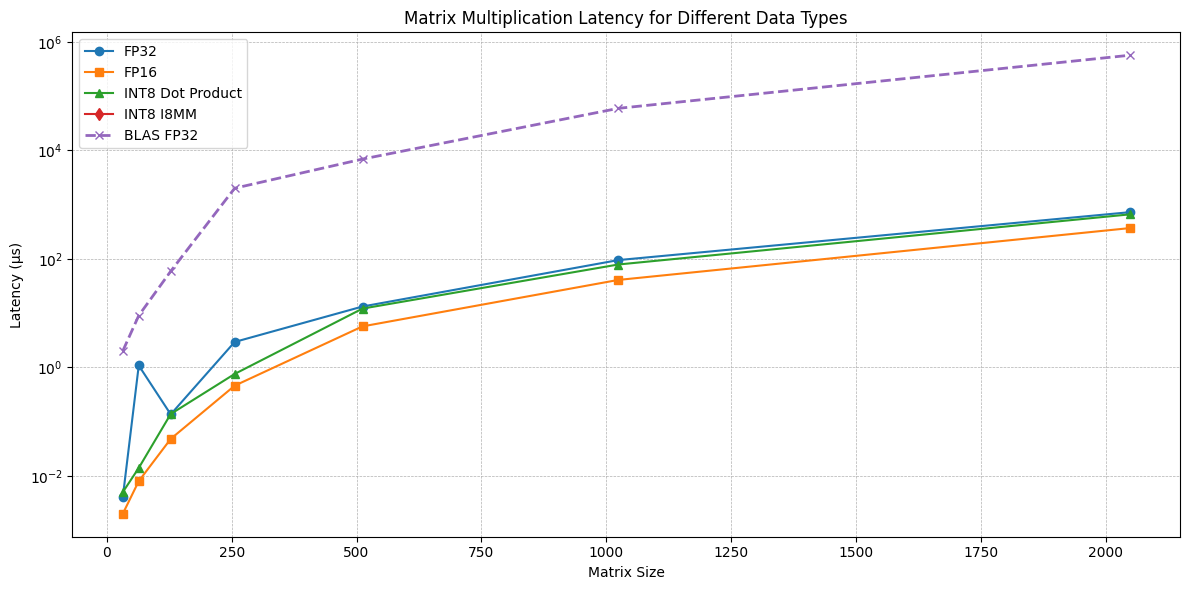

In [35]:
import matplotlib.pyplot as plt 
import numpy as np
import pandas as pd 

# Load datasets
f32_data = pd.read_csv("src/cpp/results/f32_scaling_results.csv")
f16_data = pd.read_csv("src/cpp/results/f16_scaling_results.csv")
int8_dotprod_data = pd.read_csv("src/cpp/results/i8_dotprod_scaling_results.csv")
int8_i8mm_data = pd.read_csv("src/cpp/results/i8_i8mm_scaling_results.csv")
blas_data = pd.read_csv("src/cpp/results/blas_f32_scaling_results.csv")

# Plotting the results
plt.figure(figsize=(12, 6))

# Plot each dataset
plt.plot(f32_data['Size'], f32_data['Latency(us)'], label="FP32", marker='o')
plt.plot(f16_data['Size'], f16_data['Latency(us)'], label="FP16", marker='s')
plt.plot(int8_dotprod_data['Size'], int8_dotprod_data['Latency(us)'], label="INT8 Dot Product", marker='^')
plt.plot(int8_i8mm_data['Size'], int8_i8mm_data['Latency(us)'], label="INT8 I8MM", marker='d')
plt.plot(blas_data['Size'], blas_data['Latency(us)'], label="BLAS FP32", marker='x', linestyle='--', linewidth=2)

# Add labels and title
plt.xlabel("Matrix Size")
plt.ylabel("Latency (µs)")
plt.title("Matrix Multiplication Latency for Different Data Types")
plt.yscale('log')  # Use log scale for latency if the values span multiple orders of magnitude
plt.legend()
plt.grid(True, which="both", linestyle="--", linewidth=0.5)

# Show the plot
plt.tight_layout()
plt.show()



# watch the blas fp32 process

In [27]:
import subprocess
import os
import time
import signal

# Run the main process
process = subprocess.Popen(
    ["src/cpp/blas/build/blas_f32_inf"],
    stdout=subprocess.PIPE,
    stderr=subprocess.PIPE
)

print(f"Main process ID: {process.pid}")

Main process ID: 63043


In [28]:
!sudo ./processwatch/processwatch -p 63043 -f HasNEON -f HasSVE -f HasSVE2 -f HasMatMulInt8 -f HasDotProd 


PID      NAME             NEON     SVE      SVE2     MatMulIn DotProd  %TOTAL   TOTAL   
ALL      ALL              0.02     0.00     0.00     0.00     0.00     100.00   14469   
63043    blas_f32_inf     0.02     0.00     0.00     0.00     0.00     100.00   14469   

PID      NAME             NEON     SVE      SVE2     MatMulIn DotProd  %TOTAL   TOTAL   
ALL      ALL              0.02     0.00     0.00     0.00     0.00     100.00   16133   
63043    blas_f32_inf     0.02     0.00     0.00     0.00     0.00     100.00   16133   

PID      NAME             NEON     SVE      SVE2     MatMulIn DotProd  %TOTAL   TOTAL   
ALL      ALL              0.00     0.00     0.00     0.00     0.00     100.00   15018   
63043    blas_f32_inf     0.00     0.00     0.00     0.00     0.00     100.00   15018   

PID      NAME             NEON     SVE      SVE2     MatMulIn DotProd  %TOTAL   TOTAL   
ALL      ALL              0.01     0.00     0.00     0.00     0.00     100.00   14645   
63043    blas_f32

In [29]:
import os
import signal

os.kill(process.pid, signal.SIGTERM)

# watch the kleidiai FP32 process 

In [10]:
import subprocess
import os
import time
import signal

# Run the main process
process = subprocess.Popen(
    ["src/cpp/f32_f32_f32p/build/kai_f32_inf"],
    stdout=subprocess.PIPE,
    stderr=subprocess.PIPE
)

print(f"Main process ID: {process.pid}")

Main process ID: 62962


In [11]:
!sudo ./processwatch/processwatch -p 62962 -f HasNEON -f HasSVE -f HasSVE2 -f HasMatMulInt8 -f HasDotProd 


PID      NAME             NEON     SVE      SVE2     MatMulIn DotProd  %TOTAL   TOTAL   
ALL      ALL              70.89    0.00     0.00     0.00     0.00     100.00   14766   
62962    kai_f32_inf      70.89    0.00     0.00     0.00     0.00     100.00   14766   

PID      NAME             NEON     SVE      SVE2     MatMulIn DotProd  %TOTAL   TOTAL   
ALL      ALL              70.49    0.00     0.00     0.00     0.00     100.00   15789   
62962    kai_f32_inf      70.49    0.00     0.00     0.00     0.00     100.00   15789   

PID      NAME             NEON     SVE      SVE2     MatMulIn DotProd  %TOTAL   TOTAL   
ALL      ALL              70.65    0.00     0.00     0.00     0.00     100.00   15566   
62962    kai_f32_inf      70.65    0.00     0.00     0.00     0.00     100.00   15566   
^C


In [12]:
import os
import signal

os.kill(process.pid, signal.SIGTERM)

# watch the kleidiai FP16 process 

In [13]:
import subprocess
import os
import time
import signal

# Run the main process
process = subprocess.Popen(
    ["src/cpp/f16_f16_f16p/build/kai_f16_inf"],
    stdout=subprocess.PIPE,
    stderr=subprocess.PIPE
)

print(f"Main process ID: {process.pid}")

Main process ID: 62971


In [14]:
!sudo ./processwatch/processwatch -p 62971 -f HasNEON -f HasSVE -f HasSVE2 -f HasMatMulInt8 -f HasDotProd 


PID      NAME             NEON     SVE      SVE2     MatMulIn DotProd  %TOTAL   TOTAL   
ALL      ALL              83.74    0.00     0.00     0.00     0.00     100.00   13496   
62971    kai_f16_inf      83.74    0.00     0.00     0.00     0.00     100.00   13496   

PID      NAME             NEON     SVE      SVE2     MatMulIn DotProd  %TOTAL   TOTAL   
ALL      ALL              83.90    0.00     0.00     0.00     0.00     100.00   16269   
62971    kai_f16_inf      83.90    0.00     0.00     0.00     0.00     100.00   16269   

PID      NAME             NEON     SVE      SVE2     MatMulIn DotProd  %TOTAL   TOTAL   
ALL      ALL              83.48    0.00     0.00     0.00     0.00     100.00   15323   
62971    kai_f16_inf      83.48    0.00     0.00     0.00     0.00     100.00   15323   

PID      NAME             NEON     SVE      SVE2     MatMulIn DotProd  %TOTAL   TOTAL   
ALL      ALL              83.81    0.00     0.00     0.00     0.00     100.00   15661   
62971    kai_f16_

In [15]:
import os
import signal

os.kill(process.pid, signal.SIGTERM)

# watch the kleidiai INT8/4 DotProd process 

In [16]:
import subprocess
import os
import time
import signal

# Run the main process
process = subprocess.Popen(
    ["src/cpp/f32_i8_i4_dotprod/build/kai_i8_dotprod_inf"],
    stdout=subprocess.PIPE,
    stderr=subprocess.PIPE
)

print(f"Main process ID: {process.pid}")

Main process ID: 62978


In [17]:
!sudo ./processwatch/processwatch -p 62978 -f HasNEON -f HasSVE -f HasSVE2 -f HasMatMulInt8 -f HasDotProd 


PID      NAME             NEON     SVE      SVE2     MatMulIn DotProd  %TOTAL   TOTAL   
ALL      ALL              57.99    0.00     0.00     0.00     5.52     100.00   14667   
62978    kai_i8_dotprod_  57.99    0.00     0.00     0.00     5.52     100.00   14667   

PID      NAME             NEON     SVE      SVE2     MatMulIn DotProd  %TOTAL   TOTAL   
ALL      ALL              58.01    0.00     0.00     0.00     5.34     100.00   13953   
62978    kai_i8_dotprod_  58.01    0.00     0.00     0.00     5.34     100.00   13953   

PID      NAME             NEON     SVE      SVE2     MatMulIn DotProd  %TOTAL   TOTAL   
ALL      ALL              58.42    0.00     0.00     0.00     5.12     100.00   14065   
62978    kai_i8_dotprod_  58.42    0.00     0.00     0.00     5.12     100.00   14065   

PID      NAME             NEON     SVE      SVE2     MatMulIn DotProd  %TOTAL   TOTAL   
ALL      ALL              57.82    0.00     0.00     0.00     5.50     100.00   13947   
62978    kai_i8_d

In [19]:
import os
import signal

os.kill(process.pid, signal.SIGTERM)

# watch the kleidiai int8/4 i8mm process

In [24]:
import subprocess
import os
import time
import signal

# Run the main process
process = subprocess.Popen(
    ["src/cpp/f32_i8_i4_i8mm/build/kai_i8_i8mm_inf"],
    stdout=subprocess.PIPE,
    stderr=subprocess.PIPE
)

print(f"Main process ID: {process.pid}")

Main process ID: 63001


In [25]:
!sudo ./processwatch/processwatch -p 63001 -f HasNEON -f HasSVE -f HasSVE2 -f HasMatMulInt8 -f HasDotProd 


PID      NAME             NEON     SVE      SVE2     MatMulIn DotProd  %TOTAL   TOTAL   
ALL      ALL              41.53    0.00     0.00     6.04     0.00     100.00   15497   
63001    kai_i8_i8mm_inf  41.53    0.00     0.00     6.04     0.00     100.00   15497   

PID      NAME             NEON     SVE      SVE2     MatMulIn DotProd  %TOTAL   TOTAL   
ALL      ALL              41.84    0.00     0.00     6.56     0.00     100.00   14895   
63001    kai_i8_i8mm_inf  41.84    0.00     0.00     6.56     0.00     100.00   14895   

PID      NAME             NEON     SVE      SVE2     MatMulIn DotProd  %TOTAL   TOTAL   
ALL      ALL              42.12    0.00     0.00     6.54     0.00     100.00   14937   
63001    kai_i8_i8mm_inf  42.12    0.00     0.00     6.54     0.00     100.00   14937   

PID      NAME             NEON     SVE      SVE2     MatMulIn DotProd  %TOTAL   TOTAL   
ALL      ALL              42.37    0.00     0.00     6.25     0.00     100.00   14707   
63001    kai_i8_i

In [26]:
import os
import signal

os.kill(process.pid, signal.SIGTERM)

# Onto KLEIDIAI Integrations with torch. Lets start by using the 4bit weight only kernel

In [2]:
import torch 
import torch.nn.functional as F 
from torchao.quantization.utils import prepare_int4_weight_and_scales_and_zeros
from torchao.utils import find_multiple

### Set some matmul hyperparameters 

In [3]:
out_features = 256 
in_features = 128
groupsize = 32 
inner_k_tiles = 8

### Create the floating point matrices 

In [4]:
weight = torch.randn(out_features, in_features, dtype=torch.float32)
x = torch.randn(1, in_features, dtype=torch.float32)

## use torchao to perform the group quantization 

In [11]:
w_int4x8, scales_and_zeros = prepare_int4_weight_and_scales_and_zeros(
    weight, 
    groupsize, 
    inner_k_tiles, 
    "symmetric_groupwise", 
    precision=torch.float32,
)

### Look at the shapes to see what has been done 

In [12]:
print(f"Full Precision weights: shape {weight.shape} dtype {weight.dtype}")
print(f"Prepared weights: shape {w_int4x8.shape} dtype {w_int4x8.dtype}")
print(" ")
print("weight number equality: ", w_int4x8.numel(), "==", weight.numel()//2 + (weight.numel()//groupsize * 2))

Full Precision weights: shape torch.Size([256, 128]) dtype torch.float32
Prepared weights: shape torch.Size([1024, 18]) dtype torch.uint8
 
weight number equality:  18432 == 18432


**Explanation of the Prepared Weights Size**

We can see above that the following equality between the number of weights in the prepared quantized weights (w-int4x8) and the original weights (weight) is true. 

```python
w_int4x8.numel() == (weight.numel() // 2) + (weight.numel() // groupsize * 2) 
```

***NOTE: weight.numel() gives the number of elements inside a pytorch tensor***

This can be explained by our use of 4-bit quantization in which we need to pack the quantized weights in addition to it's scale parameters into the w_int4x8 tensor. To do so, this can be interpreted in two parts:

1. **Half the number of weights**:  
   - Because each original weight is mapped to a 4-bit number, and two 4-bit values fit in a single byte, we only need half as many bytes as the total number of full-precision weights.  
   - This is expressed by `(weight.numel() // 2)` in the weight number equality.

2. **Storage for scale parameters**:  
   - Each group of weights has a corresponding scale factor, and the number of groups is `(weight.numel() // groupsize)`.  
   - These scale factors are stored in `float16` format, which requires 2 bytes for each scale, leading to `* 2`.  
   - Hence, the term `(weight.numel() // groupsize * 2)` accounts for the total bytes needed for all scale factors.

Therefore, when you add these two parts:

```python
(weight.numel() // 2) + (weight.numel() // groupsize * 2) 
```

you get the total storage (in bytes) for the quantized weights plus the scale parameters. This total matches the number of elements in `w_int4x8`, ensuring the shape `torch.Size([1024, 18])` correctly reflects both packed 4-bit weights and their scale factors.


**Explanation of the Prepared Weights shape**

In [13]:
w_int4x8.shape

torch.Size([1024, 18])

The weight preparation function has performed group quantization, quantizing each group to a single row in the matrix. This gives `weight.numel()s//group_size` rows. We can check that it is true using the below line 

In [14]:
weight.numel() // groupsize

1024

ok so that means that there is one group per row, each one with their own scale parameter. Given that the groupsize we have used is 32, and when using 4-bit quantization we can pack 2 elemtns into a single byte, that gives a row size of 16 bytes. This leaves a discrepancy of 2 bytes. This 2 byte difference is used to hold the symmetric scale parameter in float16 format. Therefore the row size of w_int4x8 is: 

In [15]:
groupsize // 2 + 2

18

# Lets now use the kleidiai kernel that has been integrated into torch 
after performing the quantization, we must pack the weight into a shape required by the kleidiai kernels. This, is a memory optimization step. 

In [16]:
weight_int4pack = torch.ops.aten._kai_weight_pack_int4(w_int4x8, scales_and_zeros.float(), out_features, in_features, groupsize)

# define a forward function to use the kleidi kernel 

In [17]:
def linear_forward_int4_symmetric_groupwise(x, weight_int4pack, out_features, in_features):
    origin_x_size = x.size()
    c = torch.ops.aten._kai_input_quant_mm_int4(x, weight_int4pack, x.shape[-2],out_features, in_features, 32)
    new_shape = origin_x_size[:-1] + (out_features,)
    c = c.reshape(new_shape)
    return c


In [18]:
out_kai = linear_forward_int4_symmetric_groupwise(x, weight_int4pack, out_features, in_features)

# lets check the quantization error compared to the fp32 multiplication 

In [19]:
out_baseline = torch.matmul(x, weight.T) # compute the baseline operation
print(out_kai.flatten()[:5])
print(out_baseline.flatten()[:5])
error = (out_baseline - out_kai).abs() / out_baseline.abs()

tensor([ 10.9846,   1.1780,  -7.9211, -27.6547,   7.8432])
tensor([ 11.0270,   1.5671,  -7.9187, -27.7170,   8.7556])


2025-01-02:09:33:25,648 INFO     [font_manager.py:1639] generated new fontManager


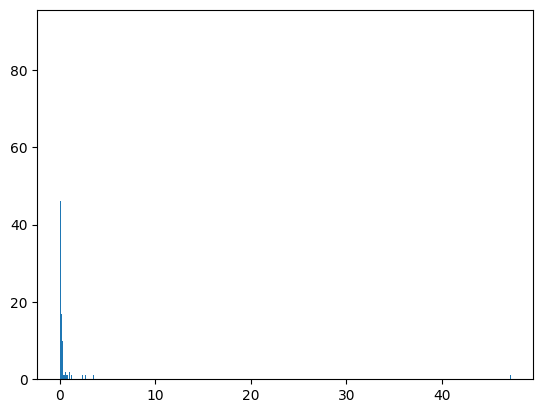

In [20]:
import matplotlib.pyplot as plt 
plt.hist(error.flatten().numpy(), bins=1000)
plt.show()

## Quantizing a LLM with KLEIDAI 

In [5]:
import torch
import transformers
from transformers import AutoModelForCausalLM, AutoTokenizer


model = AutoModelForCausalLM.from_pretrained("apple/OpenELM-270M-Instruct", trust_remote_code=True)
tokenizer = AutoTokenizer.from_pretrained("meta-llama/Llama-2-7b-hf", trust_remote_code=True)

prompt = "Arm is a company that" 
inputs = tokenizer(prompt, return_tensors="pt")

measure original memory consumption

In [6]:
import torch

baseline_memory_consumption = 0  # Memory in bytes
for name, param in model.named_parameters():  # Use model.named_parameters() to iterate over model parameters
    baseline_memory_consumption += param.numel() * param.element_size()

# Convert to megabytes (MB)
baseline_memory_consumption_mb = baseline_memory_consumption / (1024 ** 2)

print(f"Baseline memory consumption: {baseline_memory_consumption_mb:.2f} MB")

Baseline memory consumption: 1035.79 MB


measure baseline generation latency 

In [7]:
import time
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token
    
baseline_latency = 0
for _ in range(10):
    st = time.time()
    model.generate(inputs["input_ids"], attention_mask=inputs["attention_mask"], pad_token_id=tokenizer.pad_token_id, max_length=20)
    et = time.time()
    baseline_latency += (et - st) * 1000
baseline_latency /= 10

print(f"Time taken: {baseline_latency:.2f} ms")

Time taken: 476.06 ms


Look at the generation output 

In [8]:
generated_ids = model.generate(inputs["input_ids"], attention_mask=inputs["attention_mask"], pad_token_id=tokenizer.pad_token_id, max_length=20)
generated_text_fp = tokenizer.decode(generated_ids[0], skip_special_tokens=True)
generated_text_fp

'Arm is a company that has been in the business of manufacturing and supplying various types of'

# Using TorchAO quantizer 

In [9]:
from src.python.kai_quantization import Int4WeightOnlyQuantizer

precision = torch.float32
groupsize = 32
inner_k_tiles = 8 
padding_allowed = False
scheme = "symmetric_groupwise"

In [10]:
quantizer = Int4WeightOnlyQuantizer(groupsize=groupsize, inner_k_tiles=inner_k_tiles, padding_allowed=padding_allowed, scheme=scheme, precision=precision)
qmodel = quantizer.quantize(model)

2025-01-02:10:09:56,785 INFO     [kai_quantization.py:748] linear: transformer.layers.0.attn.qkv_proj, in=1280, out=1152
2025-01-02:10:09:56,794 INFO     [kai_quantization.py:748] linear: transformer.layers.0.attn.out_proj, in=768, out=1280
2025-01-02:10:09:56,803 INFO     [kai_quantization.py:748] linear: transformer.layers.0.ffn.proj_1, in=1280, out=1536
2025-01-02:10:09:56,814 INFO     [kai_quantization.py:748] linear: transformer.layers.0.ffn.proj_2, in=768, out=1280
2025-01-02:10:09:56,822 INFO     [kai_quantization.py:748] linear: transformer.layers.1.attn.qkv_proj, in=1280, out=1152
2025-01-02:10:09:56,831 INFO     [kai_quantization.py:748] linear: transformer.layers.1.attn.out_proj, in=768, out=1280
2025-01-02:10:09:56,839 INFO     [kai_quantization.py:748] linear: transformer.layers.1.ffn.proj_1, in=1280, out=2048
2025-01-02:10:09:56,851 INFO     [kai_quantization.py:748] linear: transformer.layers.1.ffn.proj_2, in=1024, out=1280
2025-01-02:10:09:56,860 INFO     [kai_quantizat

## Measure Quantized Memory Consumption

In [11]:
import torch

quantized_memory_consumption = 0  # Memory in bytes
for name, param in qmodel.state_dict().items():  # Use model.named_parameters() to iterate over model parameters
    quantized_memory_consumption += param.numel() * param.element_size()

# Convert to megabytes (MB
quantized_memory_consumption = quantized_memory_consumption / (1024 ** 2)
print(f"Baseline memory consumption: {quantized_memory_consumption:.2f} MB")

Baseline memory consumption: 280.08 MB


## Measure Model Latency

In [12]:
import time

quantized_latency = 0
for _ in range(10):
    st = time.time()
    qmodel.generate(inputs["input_ids"], attention_mask=inputs["attention_mask"], pad_token_id=tokenizer.pad_token_id, max_length=20)
    et = time.time()
    quantized_latency += (et - st) * 1000
quantized_latency /= 10

print(f"Time taken: {baseline_latency:.2f} ms")

Time taken: 476.06 ms


In [13]:
generated_ids = qmodel.generate(inputs["input_ids"], attention_mask=inputs["attention_mask"], pad_token_id=tokenizer.pad_token_id, max_length=20)
generated_text = tokenizer.decode(generated_ids[0], skip_special_tokens=True)
print(generated_text)

Arm is a company that specializes in the design, manufacture, and installation of custom-
